# Principal Components Analysis lab

To explore our first PCA problem, let's look at a food nutrition data set. This data set stores certain foods and their nutritional values. We'd like to reduce the dimension of this data set.

In [274]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
% matplotlib inline

In [275]:
data = pd.read_csv('nndb.csv', index_col=0)

In [276]:
data.head()

,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,Carb_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
ID,,,,,,,,,,,,,,,,,,,,,
1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717,0.85,81.11,0.06,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717,0.85,81.11,0.06,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876,0.28,99.48,0.00,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353,21.40,28.74,2.34,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371,23.24,29.68,2.79,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


As mentioned in the lecture, PCA creates a feature subspace that maximizes the variance, so it makes sense to standardize the data, especially when the data is measured on different scales. Let's transform the data on a unit scale (mean 0 and variance 1). It is always required if you want to get an optimal performance for PCA.

## Perform an exploratory data analysis

Before we start, let's have a quick exploratory look at the data. Let's generate the correlation heatmap to see if we can detect anything extraordinary.

In [277]:
names = list(data)

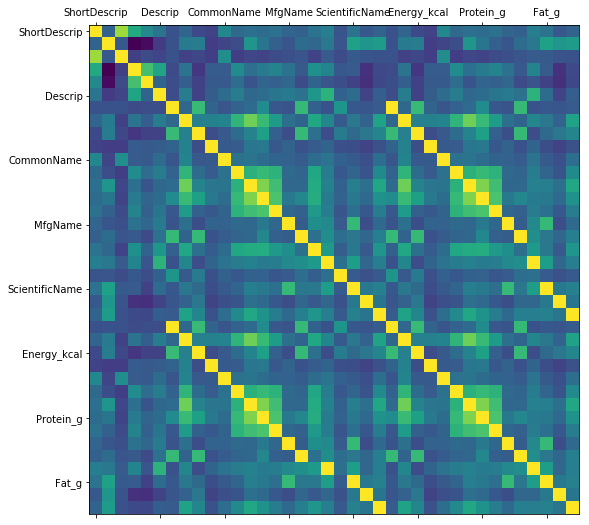

In [278]:
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
ax.matshow(data.corr());

Turns out that the "USRDA" features are perfectly correlated with some other features in the data set. Let's have a closer look at some of them.

In [279]:
np.corrcoef(data['VitA_mcg'], data['VitA_USRDA'])

array([[1., 1.],
       [1., 1.]])

In [280]:
np.corrcoef(data['VitB6_mg'], data['VitB6_USRDA'])

array([[1., 1.],
       [1., 1.]])

In [281]:
data.drop(data.columns[data.columns.str.contains('USRDA')].values, inplace=True, axis=1)

The first three columns are descriptive, the next three are empty. We won't use them in our principal component analysis, so let's go and separate them from the values which we'll use in the PCA, so we can look at the data distributions of the columns that matter.

In [282]:
data_desc = data.iloc[:, :3]
data.drop(data.columns[:6].values, axis=1, inplace=True)

In [283]:
data.head()

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
ID,,,,,,,,,,,,,,,,,,,,,
1001,717,0.85,81.11,0.06,0.06,0.0,684,0.003,0.17,0.0,...,0.034,0.005,24,0.000,0.02,2,0.000,24,1.0,0.09
1002,717,0.85,81.11,0.06,0.06,0.0,684,0.003,0.13,0.0,...,0.034,0.005,24,0.016,0.16,2,0.004,23,1.0,0.05
1003,876,0.28,99.48,0.00,0.00,0.0,840,0.001,0.01,0.0,...,0.005,0.001,4,0.001,0.00,0,0.000,3,0.0,0.01
1004,353,21.40,28.74,2.34,0.50,0.0,198,0.166,1.22,0.0,...,0.382,0.029,528,0.040,0.31,23,0.009,387,14.5,2.66
1005,371,23.24,29.68,2.79,0.51,0.0,292,0.065,1.26,0.0,...,0.351,0.014,674,0.024,0.43,24,0.012,451,14.5,2.60


## Explore the data distributions

Now that we have all the data we'll use in our PCA in one place, we can have a look at their distributions. We can use `.describe()` to get a sense of what our data looks like. Have a look at the distribution. Anything that's striking here? 

In [284]:
data.describe()

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
count,8618.000000,8618.00000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,...,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000,8618.000000
mean,226.438617,11.52391,10.647024,21.819062,6.560253,2.023242,93.968786,0.264369,1.225260,7.925377,...,0.237248,0.209857,73.411348,0.172181,2.696771,32.745301,0.504439,155.986308,12.614945,1.970216
std,169.388910,10.55059,15.866353,27.239000,13.602098,4.313670,779.362205,0.478614,4.319183,57.582758,...,0.449880,0.518369,201.363662,0.553052,5.726967,56.068454,6.383438,203.093234,28.292347,3.358213
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.000000,2.47000,0.992500,0.040000,0.000000,0.000000,0.000000,0.034250,0.000000,0.000000,...,0.046000,0.030000,9.000000,0.030000,0.530000,10.000000,0.000000,37.000000,0.100000,0.230000
50%,191.000000,8.28500,5.235000,8.945000,0.370000,0.300000,1.500000,0.120000,0.080000,0.000000,...,0.150000,0.077500,19.000000,0.079000,1.330000,20.000000,0.022000,133.000000,3.900000,0.845000
75%,336.000000,19.97750,13.900000,32.900000,5.300000,2.400000,21.000000,0.355000,1.297500,2.500000,...,0.260000,0.223000,62.000000,0.144750,2.580000,29.000000,0.222000,216.000000,21.300000,2.700000
max,902.000000,88.32000,100.000000,100.000000,99.800000,79.000000,30000.000000,12.000000,98.890000,2400.000000,...,17.500000,23.375000,7364.000000,15.050000,123.600000,781.000000,328.000000,9918.000000,1917.000000,90.950000


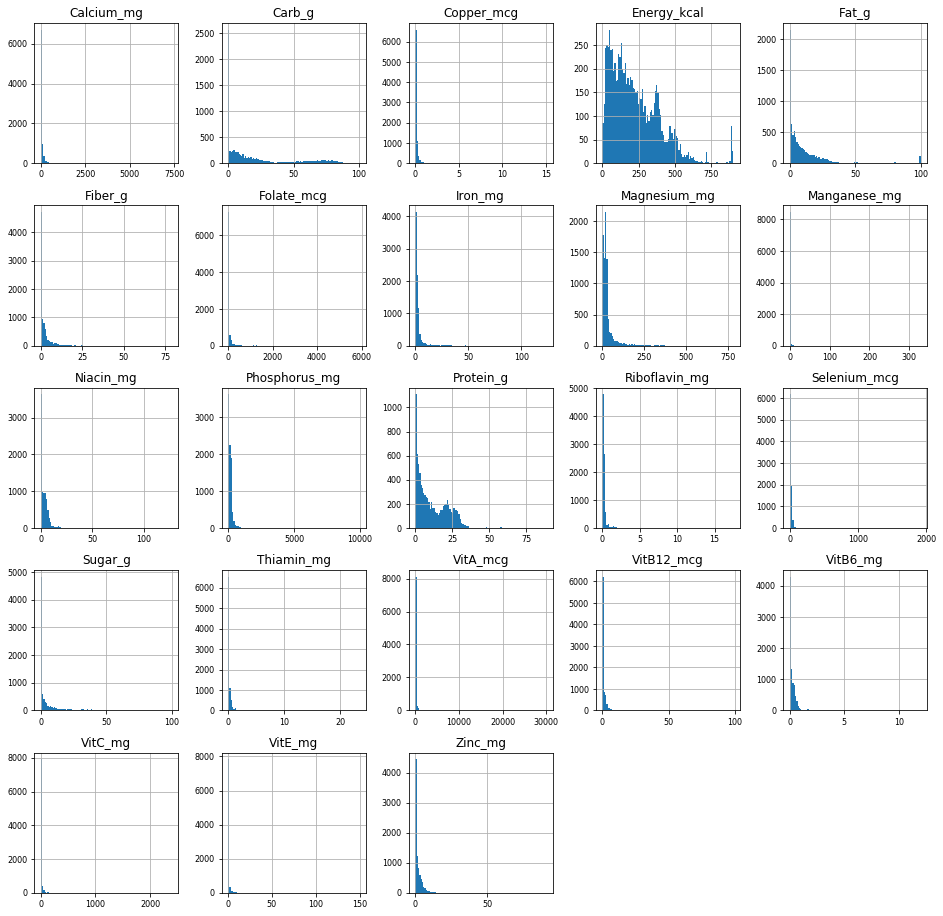

In [285]:
ax = data.hist(bins=100, xlabelsize=8, ylabelsize= 8, figsize=(16,16))

You can see that there are many 0s in this data set. You should keep in mind that this might make your results worse. What we can do is standardize our data, as seen in the lecture. This will not solve the zero-inflation (except that now the inflated values will most likely be different from zero).

In [286]:
avg = data.mean()
std_err = data.std()
data_stdized= (data - avg)/ std_err

In [287]:
data_stdized.head()

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
ID,,,,,,,,,,,,,,,,,,,,,
1001,2.896066,-1.011689,4.441032,-0.798820,-0.477886,-0.46903,0.757069,-0.546096,-0.244319,-0.137635,...,-0.451783,-0.395195,-0.245384,-0.311329,-0.467398,-0.548353,-0.079023,-0.649880,-0.410533,-0.559886
1002,2.896066,-1.011689,4.441032,-0.798820,-0.477886,-0.46903,0.757069,-0.546096,-0.253580,-0.137635,...,-0.451783,-0.395195,-0.245384,-0.282399,-0.442952,-0.548353,-0.078396,-0.654804,-0.410533,-0.571797
1003,3.834734,-1.065714,5.598828,-0.801023,-0.482297,-0.46903,0.957233,-0.550275,-0.281363,-0.137635,...,-0.516245,-0.402912,-0.344706,-0.309521,-0.470890,-0.584024,-0.079023,-0.753281,-0.445878,-0.583708
1004,0.747165,0.936070,1.140336,-0.715117,-0.445538,-0.46903,0.133482,-0.205529,-0.001218,-0.137635,...,0.321756,-0.348896,2.257551,-0.239003,-0.416760,-0.173811,-0.077613,1.137476,0.066628,0.205402
1005,0.853429,1.110468,1.199581,-0.698596,-0.444803,-0.46903,0.254094,-0.416555,0.008043,-0.137635,...,0.252849,-0.377833,2.982607,-0.267934,-0.395806,-0.155975,-0.077143,1.452602,0.066628,0.187536


### Another way to standardize the data

In [288]:
from sklearn.preprocessing import StandardScaler
data_stand = StandardScaler().fit_transform(data)
data_stand = pd.DataFrame(data_stand)

In [289]:
data_stand.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,2.896234,-1.011747,4.441289,-0.798867,-0.477914,-0.469058,0.757113,-0.546128,-0.244334,-0.137643,...,-0.451809,-0.395218,-0.245398,-0.311347,-0.467425,-0.548385,-0.079028,-0.649918,-0.410557,-0.559918
1,2.896234,-1.011747,4.441289,-0.798867,-0.477914,-0.469058,0.757113,-0.546128,-0.253595,-0.137643,...,-0.451809,-0.395218,-0.245398,-0.282415,-0.442978,-0.548385,-0.078401,-0.654842,-0.410557,-0.571830
2,3.834956,-1.065776,5.599153,-0.801069,-0.482325,-0.469058,0.957289,-0.550307,-0.281380,-0.137643,...,-0.516275,-0.402935,-0.344726,-0.309539,-0.470917,-0.584057,-0.079028,-0.753325,-0.445904,-0.583742
3,0.747208,0.936124,1.140402,-0.715158,-0.445564,-0.469058,0.133490,-0.205541,-0.001218,-0.137643,...,0.321775,-0.348916,2.257682,-0.239017,-0.416784,-0.173821,-0.077618,1.137542,0.066632,0.205414
4,0.853478,1.110532,1.199651,-0.698637,-0.444829,-0.469058,0.254109,-0.416579,0.008044,-0.137643,...,0.252864,-0.377855,2.982780,-0.267949,-0.395829,-0.155984,-0.077148,1.452687,0.066632,0.187546


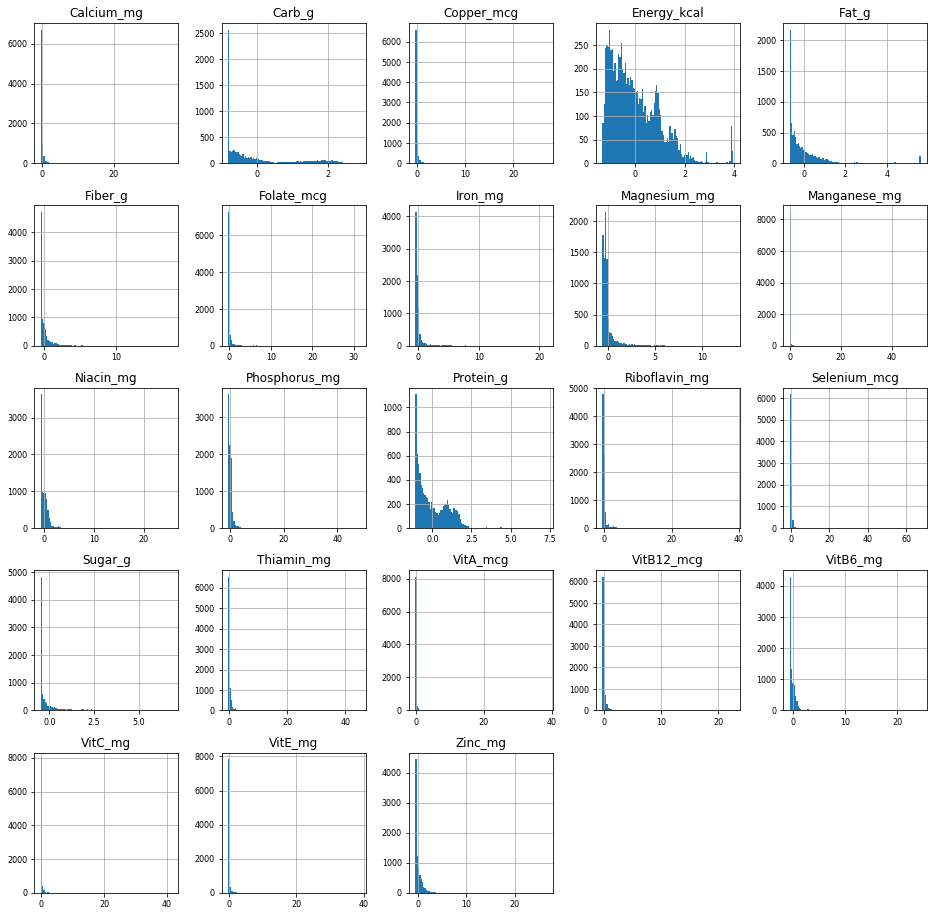

In [290]:
ax = data_stdized.hist(bins=100, xlabelsize= 8, ylabelsize= 8 , figsize=(16,16))

In [291]:
#data_stand = pd.DataFrame(data_stand) 
#data_stand.columns = list(data)
#ax = data_stdized.hist(bins=100, xlabelsize=8, ylabelsize=8, figsize=(16,16))

We standardized the data, but the data doesn't necessarily look a lot better. Let's look at our correlation structure again, yet let's now formalize compute the correlation coefficient.

## The correlation matrix

As you saw in the lecture, the sample covariance matrix is given by:

\begin{equation}
\mathbf{S} = \begin{bmatrix}
    s^2_{1} & s_{12}  & \dots  & s_{1p} \\
    s_{21} & s^2_{2}  & \dots  & s_{2p} \\
    \vdots & \vdots & \ddots & \vdots \\
    s_{p1} & s_{p2} & \dots  & s^2_{p}
\end{bmatrix}
\end{equation}

with

$s_{jk} = \dfrac{\sum_{i=1}^n (X_{ij}-\bar X_{.j})(X_{ij}-\bar X_{.k})}{n-1}= \dfrac{\sum_{i=1}^n x_{ij}x_{ik}}{n-1}$

Recall that we are working with standardized variables here, so we can actually get to the correlations as follows:
$r_{jk} = \dfrac{\sum_{i=1}^n z_{ij}z_{ik}}{n-1}$. Doing this in Python:

In [314]:
cov_mat = (data_stdized.T.dot(data_stdized)) / (data_stdized.shape[0]-1)

In [315]:
cov_mat

,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,...,Riboflavin_mg,Thiamin_mg,Calcium_mg,Copper_mcg,Iron_mg,Magnesium_mg,Manganese_mg,Phosphorus_mg,Selenium_mcg,Zinc_mg
Energy_kcal,1.000000,0.110302,0.806795,0.487096,0.313151,0.197338,0.026329,0.121872,-0.012292,-0.033495,...,0.155830,0.187439,0.123571,0.099513,0.195564,0.255880,0.037621,0.195181,0.056673,0.112766
Protein_g,0.110302,1.000000,0.054715,-0.301974,-0.266170,-0.072777,0.026483,0.228485,0.245423,-0.066456,...,0.202480,0.098360,0.046888,0.158900,0.126375,0.218611,0.039742,0.444608,0.378369,0.416315
Fat_g,0.806795,0.054715,1.000000,-0.054116,-0.001962,-0.028842,0.024379,-0.046950,-0.020786,-0.059993,...,-0.036286,-0.005785,0.015039,0.042765,-0.040408,0.070781,-0.000592,0.066086,0.037559,0.028264
Carb_g,0.487096,-0.301974,-0.054116,1.000000,0.615344,0.458192,0.001871,0.195571,-0.094636,0.076745,...,0.232408,0.281809,0.189106,0.062106,0.350463,0.287207,0.055570,0.073180,-0.114600,-0.012187
Sugar_g,0.313151,-0.266170,-0.001962,0.615344,1.000000,0.115916,0.010143,0.088767,-0.050450,0.064152,...,0.125225,0.097751,0.129540,-0.005837,0.117765,0.041308,0.010871,-0.049784,-0.123708,-0.021991
Fiber_g,0.197338,-0.072777,-0.028842,0.458192,0.115916,1.000000,0.005910,0.242804,-0.052045,0.081852,...,0.157703,0.205211,0.232286,0.185044,0.386710,0.542038,0.101661,0.158422,-0.035897,0.085154
VitA_mcg,0.026329,0.026483,0.024379,0.001871,0.010143,0.005910,1.000000,0.136605,0.581004,0.111279,...,0.325709,0.052921,0.034822,0.569945,0.103475,0.024572,0.369993,0.055814,0.048043,0.070541
VitB6_mg,0.121872,0.228485,-0.046950,0.195571,0.088767,0.242804,0.136605,1.000000,0.264325,0.271305,...,0.581678,0.417011,0.177268,0.116326,0.477905,0.293169,0.066876,0.213395,0.109004,0.447143
VitB12_mcg,-0.012292,0.245423,-0.020786,-0.094636,-0.050450,-0.052045,0.581004,0.264325,1.000000,0.007264,...,0.436182,0.099601,0.011715,0.570642,0.177334,0.004124,0.242112,0.148774,0.215308,0.298136
VitC_mg,-0.033495,-0.066456,-0.059993,0.076745,0.064152,0.081852,0.111279,0.271305,0.007264,1.000000,...,0.225928,0.056987,0.111825,0.025460,0.074417,0.115222,0.017942,0.012000,-0.035218,0.018476


### Or, easier

In [317]:
pd.DataFrame(np.cov(data_stdized.T))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.000000,0.110302,0.806795,0.487096,0.313151,0.197338,0.026329,0.121872,-0.012292,-0.033495,...,0.155830,0.187439,0.123571,0.099513,0.195564,0.255880,0.037621,0.195181,0.056673,0.112766
1,0.110302,1.000000,0.054715,-0.301974,-0.266170,-0.072777,0.026483,0.228485,0.245423,-0.066456,...,0.202480,0.098360,0.046888,0.158900,0.126375,0.218611,0.039742,0.444608,0.378369,0.416315
2,0.806795,0.054715,1.000000,-0.054116,-0.001962,-0.028842,0.024379,-0.046950,-0.020786,-0.059993,...,-0.036286,-0.005785,0.015039,0.042765,-0.040408,0.070781,-0.000592,0.066086,0.037559,0.028264
3,0.487096,-0.301974,-0.054116,1.000000,0.615344,0.458192,0.001871,0.195571,-0.094636,0.076745,...,0.232408,0.281809,0.189106,0.062106,0.350463,0.287207,0.055570,0.073180,-0.114600,-0.012187
4,0.313151,-0.266170,-0.001962,0.615344,1.000000,0.115916,0.010143,0.088767,-0.050450,0.064152,...,0.125225,0.097751,0.129540,-0.005837,0.117765,0.041308,0.010871,-0.049784,-0.123708,-0.021991
5,0.197338,-0.072777,-0.028842,0.458192,0.115916,1.000000,0.005910,0.242804,-0.052045,0.081852,...,0.157703,0.205211,0.232286,0.185044,0.386710,0.542038,0.101661,0.158422,-0.035897,0.085154
6,0.026329,0.026483,0.024379,0.001871,0.010143,0.005910,1.000000,0.136605,0.581004,0.111279,...,0.325709,0.052921,0.034822,0.569945,0.103475,0.024572,0.369993,0.055814,0.048043,0.070541
7,0.121872,0.228485,-0.046950,0.195571,0.088767,0.242804,0.136605,1.000000,0.264325,0.271305,...,0.581678,0.417011,0.177268,0.116326,0.477905,0.293169,0.066876,0.213395,0.109004,0.447143
8,-0.012292,0.245423,-0.020786,-0.094636,-0.050450,-0.052045,0.581004,0.264325,1.000000,0.007264,...,0.436182,0.099601,0.011715,0.570642,0.177334,0.004124,0.242112,0.148774,0.215308,0.298136
9,-0.033495,-0.066456,-0.059993,0.076745,0.064152,0.081852,0.111279,0.271305,0.007264,1.000000,...,0.225928,0.056987,0.111825,0.025460,0.074417,0.115222,0.017942,0.012000,-0.035218,0.018476


In Python, numpy stores quite a few linear algebra functions which makes eigendecomposition easy.

## Eigendecomposition

In [323]:
eig_values, eig_vectors = np.linalg.eig(cov_mat)

In [324]:
eig_values

array([5.44928576e+00, 2.61845835e+00, 2.03189759e+00, 1.87913144e+00,
       1.63567140e+00, 1.14037066e+00, 1.06086727e+00, 3.79524723e-03,
       9.26253795e-01, 8.62018168e-01, 8.24686441e-01, 7.31232556e-01,
       5.96894964e-01, 1.59093679e-01, 5.08653057e-01, 4.69461661e-01,
       2.11158912e-01, 4.07986316e-01, 2.38139303e-01, 2.56202403e-01,
       3.37934003e-01, 3.29568690e-01, 3.21238326e-01])

In [325]:
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]

In [334]:
eig_pairs.sort()
eig_pairs.reverse()

In [337]:
eig_pairs[0:5]

[(5.449285764311524,
  array([-0.15781363, -0.1406199 , -0.03300812, -0.16968451, -0.07632275,
         -0.18156988, -0.13351884, -0.31566282, -0.17798456, -0.08763937,
         -0.13712201, -0.28410233, -0.33777895, -0.34132464, -0.27245318,
         -0.16811197, -0.18080591, -0.2998569 , -0.24134847, -0.09356749,
         -0.19940258, -0.0923186 , -0.24355123])),
 (2.6184583526663863,
  array([ 0.27344866, -0.34339677,  0.11167035,  0.44341644,  0.35876913,
          0.25773287, -0.23647025, -0.02112889, -0.35504461,  0.03852455,
          0.10637166,  0.09709328, -0.08480073, -0.07347102,  0.0751503 ,
          0.10517259, -0.21266898,  0.09381195,  0.10336119, -0.08878313,
         -0.08744763, -0.23932243, -0.17779772])),
 (2.0318975882591297,
  array([-0.46200619, -0.21356699, -0.53405101,  0.04982164,  0.05524693,
         -0.0403974 , -0.02192922,  0.1746476 , -0.0127601 ,  0.1623026 ,
         -0.2073308 ,  0.230985  ,  0.16488461,  0.19209808,  0.18435137,
         -0.1281385

# Implement PCA

In [25]:
# from sklearn.decomposition import PCA
fit = PCA()
pca = fit.fit_transform(df_TF)


#### check the eigenvalues to find most important components


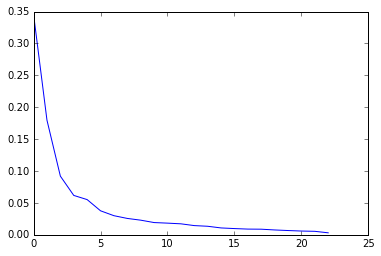

In [26]:
plt.plot(fit.explained_variance_ratio_)

In [27]:
print fit.explained_variance_ratio_
print fit.explained_variance_ratio_[:5].sum()

[ 0.34554936  0.17971019  0.09201387  0.06176452  0.05520037  0.03764111
  0.02996247  0.02566808  0.02294417  0.0192006   0.01828886  0.01721459
  0.01443828  0.01337614  0.0107629   0.00977106  0.00894584  0.00878398
  0.00760274  0.00668982  0.00589323  0.00545379  0.00312402]
0.734238306777


#### the first 5 eigenvectors account for 77% of the variance and will be kept

In [39]:
pca = pd.DataFrame(pca[:, :5], index=df.index)
pca = pca.join(df_desc)
pca.drop(['CommonName','MfgName','ScientificName'], axis=1, inplace=True)
pca.rename(columns={0:'c1',1:'c2',2:'c3',3:'c4',4:'c5'}, inplace=True)

In [40]:
# we see that the five vectors are orthogonal
np.round(pca.corr(), 5)

,c1,c2,c3,c4,c5
c1,1.0,-0.0,-0.0,-0.0,0.0
c2,-0.0,1.0,0.0,0.0,-0.0
c3,-0.0,0.0,1.0,0.0,-0.0
c4,-0.0,0.0,0.0,1.0,0.0
c5,0.0,-0.0,-0.0,0.0,1.0


## Try to interpret the components

(this is where deep subject matter expertise, in this case nutrition, comes in handy)

**Component one** 

foods that are high in: zinc, and other vitamins and minerals

low in: sugar, vitamin C, Carbs, and fiber

In [17]:
vects = fit.components_[:5]

one = pd.Series(vects[0], index=df.columns)
one.sort_values(ascending=False)

Zinc_mg          0.308506
Phosphorus_mg    0.305000
Niacin_mg        0.294094
Protein_g        0.286086
Riboflavin_mg    0.282687
VitB6_mg         0.270646
Selenium_mcg     0.264114
Iron_mg          0.262314
Magnesium_mg     0.260245
Thiamin_mg       0.235440
VitB12_mcg       0.221322
Copper_mcg       0.220232
Folate_mcg       0.167856
Energy_kcal      0.165126
Fat_g            0.161488
Calcium_mg       0.135512
VitE_mg          0.090808
Manganese_mg     0.088762
VitA_mcg         0.056996
Fiber_g         -0.004663
Carb_g          -0.033767
VitC_mg         -0.069830
Sugar_g         -0.076132
dtype: float64

**Component two**

High: Carbs, Fiber, Mang, Sugar, Vitamin C...

Low: Vitamine B12, protein, selenium, Fat...

In [18]:
two = pd.Series(vects[1], index=df.columns)
two.sort_values(ascending=False)

Carb_g           0.414542
Fiber_g          0.397832
Manganese_mg     0.343603
Sugar_g          0.295640
VitC_mg          0.242314
Folate_mcg       0.238391
Calcium_mg       0.231052
Magnesium_mg     0.199838
Copper_mcg       0.181631
Thiamin_mg       0.159641
Iron_mg          0.118917
VitE_mg          0.104310
VitA_mcg         0.095701
Energy_kcal      0.041850
Riboflavin_mg    0.024241
Phosphorus_mg   -0.001517
VitB6_mg        -0.052166
Niacin_mg       -0.064197
Zinc_mg         -0.100529
Fat_g           -0.123575
Selenium_mcg    -0.138883
Protein_g       -0.196127
VitB12_mcg      -0.265671
dtype: float64

**Component three**

High: calories, fat, carbs, sugar...

Low: vitamin A, vitamin C, folate, copper...

In [19]:
three = pd.Series(vects[2], index=df.columns)
three.sort_values(ascending=False)

Energy_kcal      0.508062
Fat_g            0.409505
Carb_g           0.250952
Sugar_g          0.208651
Thiamin_mg       0.191124
Fiber_g          0.153640
Iron_mg          0.115065
Riboflavin_mg    0.062074
Niacin_mg        0.055991
Protein_g        0.026828
Phosphorus_mg   -0.010948
VitE_mg         -0.012473
Zinc_mg         -0.051002
Magnesium_mg    -0.100792
VitB12_mcg      -0.107476
Manganese_mg    -0.108755
VitB6_mg        -0.121850
Calcium_mg      -0.125621
Selenium_mcg    -0.131798
Copper_mcg      -0.177702
Folate_mcg      -0.264298
VitA_mcg        -0.298089
VitC_mg         -0.334490
dtype: float64

**Component four**

High: vitamin A, vitamin E, fat, sugar, calcium, vitamin B12, calories...

Low: manganese, copper, iron, magnesium, fiber

In [20]:
four = pd.Series(vects[3], index=df.columns)
four.sort_values(ascending=False)

VitA_mcg         0.539792
VitE_mg          0.537710
Fat_g            0.282774
Sugar_g          0.279657
Calcium_mg       0.188343
VitB12_mcg       0.167068
Energy_kcal      0.158787
VitC_mg          0.129288
Selenium_mcg     0.063452
Riboflavin_mg    0.061855
Folate_mcg       0.011655
VitB6_mg        -0.011382
Phosphorus_mg   -0.022623
Carb_g          -0.025185
Zinc_mg         -0.055472
Niacin_mg       -0.065223
Thiamin_mg      -0.086530
Protein_g       -0.090944
Fiber_g         -0.119122
Magnesium_mg    -0.131683
Iron_mg         -0.149698
Copper_mcg      -0.167872
Manganese_mg    -0.203804
dtype: float64

** Component five**

High: riboflavin, thiamin, niacin, sugar, vitB6, vitC, vitB12...

Low: manganese, copper, fat, vitE, calories, magnesium

In [21]:
five = pd.Series(vects[4], index=df.columns)
five.sort_values(ascending=False)

Riboflavin_mg    0.322545
Thiamin_mg       0.281944
Niacin_mg        0.264423
Sugar_g          0.264262
VitB6_mg         0.254663
VitC_mg          0.249634
VitB12_mcg       0.195637
Iron_mg          0.158585
Carb_g           0.101396
Fiber_g          0.075900
VitA_mcg         0.057928
Zinc_mg         -0.029074
Calcium_mg      -0.035398
Protein_g       -0.046148
Phosphorus_mg   -0.084178
Folate_mcg      -0.105000
Magnesium_mg    -0.143789
Selenium_mcg    -0.163561
Energy_kcal     -0.204336
VitE_mg         -0.250605
Fat_g           -0.266740
Copper_mcg      -0.316998
Manganese_mg    -0.347515
dtype: float64

## Now let's look at which food groups are highest in each component

## 1 

In [54]:
pca.sort_values(by='c1')['FoodGroup'][:500].value_counts()

Soups, Sauces, and Gravies             190
Beverages                              167
Sweets                                  45
Vegetables and Vegetable Products       20
Fruits and Fruit Juices                 16
Legumes and Legume Products             16
Baby Foods                              10
Meals, Entrees, and Side Dishes          9
Spices and Herbs                         7
Fats and Oils                            7
American Indian/Alaska Native Foods      5
Snacks                                   3
Fast Foods                               2
Baked Products                           2
Sausages and Luncheon Meats              1
Name: FoodGroup, dtype: int64

## 2

In [55]:
pca.sort_values(by='c2')['FoodGroup'][:500].value_counts()

Beef Products                          353
Lamb, Veal, and Game Products           71
Poultry Products                        21
Fats and Oils                           13
American Indian/Alaska Native Foods     13
Pork Products                            9
Finfish and Shellfish Products           8
Sausages and Luncheon Meats              4
Fast Foods                               3
Restaurant Foods                         3
Beverages                                2
Name: FoodGroup, dtype: int64

## 3

In [57]:
pca.sort_values(by='c3')['FoodGroup'][:500].value_counts()

Vegetables and Vegetable Products      344
Finfish and Shellfish Products          68
Poultry Products                        19
Beverages                               10
Soups, Sauces, and Gravies              10
Fruits and Fruit Juices                  9
Lamb, Veal, and Game Products            9
Baby Foods                               7
Spices and Herbs                         6
Fast Foods                               5
Pork Products                            4
Beef Products                            4
Nut and Seed Products                    2
American Indian/Alaska Native Foods      2
Dairy and Egg Products                   1
Name: FoodGroup, dtype: int64

## 4

In [59]:
pca.sort_values(by='c4')['FoodGroup'][:500].value_counts()

Legumes and Legume Products            124
Cereal Grains and Pasta                 98
Vegetables and Vegetable Products       89
Baked Products                          39
Nut and Seed Products                   34
Breakfast Cereals                       23
Snacks                                  19
American Indian/Alaska Native Foods     18
Beverages                               16
Sweets                                  15
Sausages and Luncheon Meats              6
Lamb, Veal, and Game Products            6
Spices and Herbs                         5
Finfish and Shellfish Products           2
Fruits and Fruit Juices                  2
Soups, Sauces, and Gravies               2
Baby Foods                               1
Poultry Products                         1
Name: FoodGroup, dtype: int64

## 5

In [60]:
pca.sort_values(by='c5')['FoodGroup'][:500].value_counts()

Fats and Oils                          145
Nut and Seed Products                   81
Sweets                                  51
Legumes and Legume Products             50
Snacks                                  41
Baked Products                          24
Sausages and Luncheon Meats             17
American Indian/Alaska Native Foods     16
Dairy and Egg Products                  13
Finfish and Shellfish Products          12
Cereal Grains and Pasta                 12
Breakfast Cereals                        8
Fast Foods                               5
Spices and Herbs                         4
Restaurant Foods                         4
Beef Products                            3
Poultry Products                         3
Beverages                                3
Pork Products                            2
Lamb, Veal, and Game Products            2
Soups, Sauces, and Gravies               1
Baby Foods                               1
Vegetables and Vegetable Products        1
Fruits and 

# Sources

https://data.world/exercises/principal-components-exercise-1